In [14]:
import sys
import pickle 

sys.path.append(sys.path[0] + "/..")  # Adds higher directory to python modules path.

import numpy as np
from Functions import renormalize, scomplex, plotting
import matplotlib.pyplot as plt
import networkx as nx

import xgi
from itertools import combinations

plt.rcParams["text.usetex"] = True


colors = ["#003F5C","#2F4B7C","#665191","#A05195","#D45087","#F95D6A","#FF7C43","#FFA600"]
colors_sequential = colors + colors + colors + colors 
colors = ["#02405c", "#fea600", "#a20655", "#5e96c5", "#4b3596", "#fa6ca9", "#8d6cf6"]
colors_curves = colors+ colors+ colors+ colors


In [11]:
import io


nverts = open("../Datasets/DAWN/DAWN-nverts.txt","r")
#simplices = open("../Datasets/DAWN/DAWN-simplices.txt","r")
f_times = open("../Datasets/DAWN/DAWN-times.txt","r")
verts = []
for line in nverts:
    verts.append(int(line))
nverts.close()
times = []
for line in f_times:
    times.append(int(line))

f_times.close()

In [21]:
np.count_nonzero(np.array(times)==8020)

57307

In [2]:
def adjacency_of_order_hypergraph(sc,k,l):
    # sc: simplicial complex object
    # k: order of the diffusing simplices
    # l: order of the interaction simplices

    keys = ["nodes", "edges", "faces", "tetrahedra", "4-simplices"]
    nk = sc[f"n{k}"]
    adj = np.zeros((nk,nk),dtype = int)

    if l < k: 
       
        diff_units = sc[keys[k]]
        
        if l == 0:
            for i in range(nk):
                for j in range(i+1,nk):
                    intersection = (set(diff_units[i,:]) & set(diff_units[j,:]))
                    adj[i,j] = 2*len(intersection)
                    
        else: 
            edge_dict, face_dict, tet_dict = scomplex.make_dict(sc)
            dicts = [{(i,):i for i in range(sc["n0"])},edge_dict,face_dict,tet_dict]
            for i in range(nk):
                for j in range(i+1,nk):
                    intersection = (set(diff_units[i,:]) & set(diff_units[j,:]))
                    combs = list(combinations(intersection, l+1))
                    for c in combs:
                        if c in dicts[l]:
                            adj[i,j] += 2
                

    elif l > k:
        edge_dict, face_dict, tet_dict = scomplex.make_dict(sc)
        dicts = [{(i,):i for i in range(sc["n0"])},edge_dict,face_dict,tet_dict]
        for i,simp in enumerate(sc[keys[l]]):
            combs = list(combinations(simp, k+1))
            ncombs = len(combs)
            combs_present = []
            for c in range(ncombs):
                if combs[c] in dicts[k]:
                    combs_present.append(dicts[k][combs[c]])

            for c1 in combs_present:
                for c2 in combs_present:
                    if c2 != c1:
                        adj[c1,c2] += 1

    return (adj + adj.T)//2

def diffusion_laplacian_hypergraph(sc,k,l):
    A = adjacency_of_order_hypergraph(sc,k,l)
    K = np.sum(A, 0)
    L = np.diag(K) - A
    return L

In [188]:
H = xgi.load_xgi_data(r"email-eu", max_order=3)

In [189]:
H.cleanup()

sc = {}
sc["nodes"] = np.sort(np.array([H.nodes]).T,0)
sc["n0"] = sc["nodes"].shape[0]
keys = ["edges","faces","tetrahedra","4-simplices"]

for k in keys:
    sc[k] = []
for e in H.edges.members():
    sc[keys[len(e)-2]].append(list(e))

for i,k in enumerate(keys):
    if len(sc[k]) == 0:
        sc[k] = np.zeros((0,i+2))
    else:
        sc[k] = np.unique(np.sort(np.array(sc[k]),1),axis =0)
    
    sc[f"n{i+1}"] = sc[k].shape[0] 



In [231]:
# Define strings which specify the Laplacians to consider

#laplacians_types = ["01","02","10","12","20","21"]
laplacians_types = ["01","02","03","10","12","13","20","21","23","30","31","32"]

# Compute eigenvalues of the Laplacians and their specific heat curves

taumin = -3 # Heat curve starts from 10**taumin
taumax = 5 # Heat curve ends at 10**taumax
ntau = 200 # Number of taus to consider in the interval

sp_heats = []

for l in laplacians_types:  
    print(f"L_({l[0]},{l[1]})")  
    L = diffusion_laplacian_hypergraph(sc, k=int(l[0]), l=int(l[1]))
    D,U = np.linalg.eigh(L)
    D = np.abs(D)

    specific_heat,tau_space, __ = renormalize.compute_heat(D,taumin,taumax,ntau)
    spectral_dimension,tau_space = renormalize.compute_spectral_d(D,taumin,taumax,ntau)
    sp_heats.append(specific_heat)


L_(0,1)


(array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 [Text(0, 0.001, '$\\mathdefault{10^{-3}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$')])

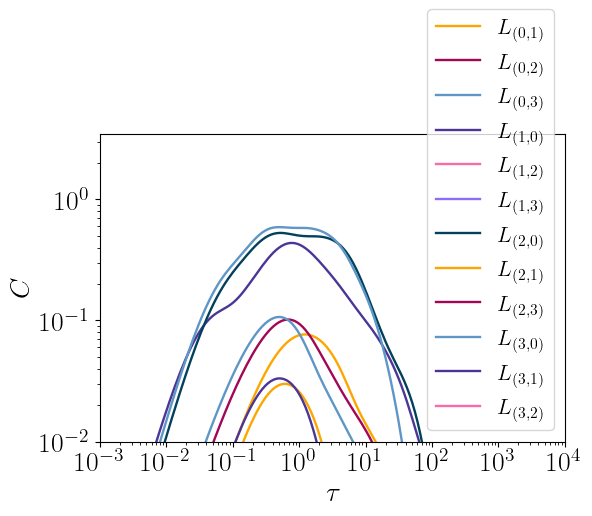

In [219]:
cols  = colors_curves
names = [f"$L_{{({int(l[0])},{int(l[1])})}}$" for l in laplacians_types]
f,ax = plt.subplots(1,1,figsize = (6,4))
for i in range(len(laplacians_types)):
    ax.loglog(tau_space,sp_heats[i],color = cols[i+1],linewidth = 1.7,alpha = 1)


ax.set_ylim([10**-2,3.5])
ax.set_xlim([10**-3,10**4])

ax.legend([names[i] for i in range(len(laplacians_types))],fontsize = 16)


ax.set_xlabel(r"$\tau$",fontsize = 20)
ax.set_ylabel(r"$C$",fontsize = 20)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

#ax.vlines(x = 4,ymin = 10**-1,ymax = 0.9,linestyles="--",color = [0.5,0.5,0.5])

In [220]:
measure = np.zeros(len(laplacians_types))
for s,specific_heat in enumerate(sp_heats):
    measure[s] = renormalize.measure_SI(tau_space,specific_heat,epsilon=0.2,ymin = -4,ymax = 2,ny = 100)

/Users/marconurisso/Desktop/Lavoro/Simplicial_Renormalization/HodgeLaplacianRenorm/higher_order_LRG/HOLR/Experiments_setups/../Functions/renormalize.py:71: RuntimeWarning: divide by zero encountered in log
  sp_heat =  np.log(sp_heat)
/Users/marconurisso/Desktop/Lavoro/Simplicial_Renormalization/HodgeLaplacianRenorm/higher_order_LRG/HOLR/Experiments_setups/../Functions/renormalize.py:71: RuntimeWarning: invalid value encountered in log
  sp_heat =  np.log(sp_heat)


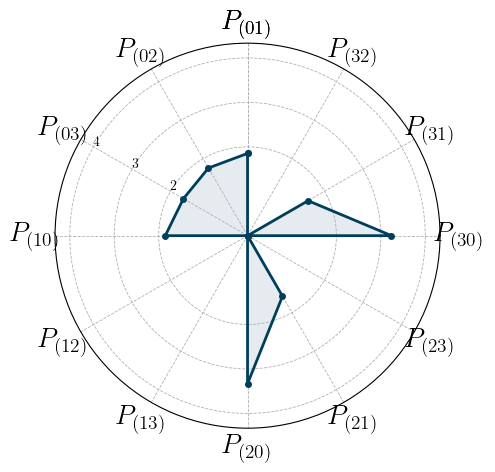

In [221]:
f = plt.figure(figsize = (5,5))
ax = plt.subplot(1,1,1,polar=True)

stats = measure
angles = np.mod(np.pi/2 + np.linspace(0, 2*np.pi, len(laplacians_types), endpoint=False),2*np.pi)

stats = np.concatenate((stats,[stats[0]]))

angles =np.concatenate((angles,[angles[0]]))
ax.plot(angles, stats, 'o-', linewidth=2,color = colors_sequential[int(np.floor(3/2*s))],markersize = 4)
ax.fill(angles, stats, alpha=0.1,color = colors_sequential[int(np.floor(3/2*s))],label = "")

ax.set_xticks(angles,[r"$P_{(%s)}$"%l for l in laplacians_types+[laplacians_types[0]]],fontsize = 20)
ax.set_rticks([2,3,4,5,6,7],fontsize = 14)
ax.set_rlabel_position(150.5)  # Move radial labels away from plotted line

ax.set_ylim(0,max(np.max(measure)+1,4))
#ax.grid(False)
ax.grid(linewidth=0.6,linestyle = '--')

In [9]:
with open(f'../../../AllSet_all_raw_data/coauthorship/dblp/hypergraph.pickle', 'rb') as handle:
    sas = pickle.load(handle)

In [10]:
sc = {"edges":[],"faces":[],"tetrahedra":[]}
for n in sas.values():
    l = len(n)
    if l == 2:
        sc["edges"].append(list(n))
    elif l == 3:
        sc["faces"].append(list(n))
    elif l == 4:
        sc["tetrahedra"].append(list(n))

sc["edges"] = np.array(sc["edges"])
sc["faces"] = np.array(sc["faces"])
sc["tetrahedra"] = np.array(sc["tetrahedra"])
sc["n1"] = sc["edges"].shape[0]
sc["n2"] = sc["faces"].shape[0]
sc["n3"] = sc["tetrahedra"].shape[0]
sc["n0"] = max(np.max(sc["edges"]),np.max(sc["faces"]),np.max(sc["tetrahedra"]))+1
sc["nodes"] = np.array([[i for i in range(sc["n0"])]]).T